## ARMA Modeling: Forecasting

**Functions**

`tsa.SARIMAX.forecast`

### Exercise 70
Produce 1-step forecasts from your preferred model in the previous exercise, as well
as a random-walk model. 

1. Are the forecasts objectively accurate?
2. Compare these forecasts to the random walk models using MSE and MAE.

**Note**: Use 50% of the sample to estimate the model and 50% to evaluate it.

In [1]:
import pandas as pd

data = pd.read_hdf("data/term-premium.h5", "term_premium")
term = data["TERM"]

In [2]:
import statsmodels.tsa.api as tsa

nobs = term.shape[0]
half = nobs // 2
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TERM   No. Observations:                  434
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -67.547
Date:                Wed, 27 Aug 2025   AIC                            143.094
Time:                        15:17:58   BIC                            159.386
Sample:                    04-01-1953   HQIC                           149.525
                         - 05-01-1989                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0550      0.021      2.663      0.008       0.015       0.095
ar.L1          0.8995      0.016     57.608      0.000       0.869       0.930
ma.L1          0.4596      0.019     24.241      0.000       0.422       0.497
sigma2         0.0795      0.003     28.189      0.000       0.074       0.085
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):              1124.05
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               6.45   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [3]:
mod = tsa.statespace.SARIMAX(term, order=(1, 0, 1), trend="c")
forecast_res = mod.filter(res.params)

fcast = forecast_res.predict()

errors = term - fcast
oos_errors = errors.iloc[half:]

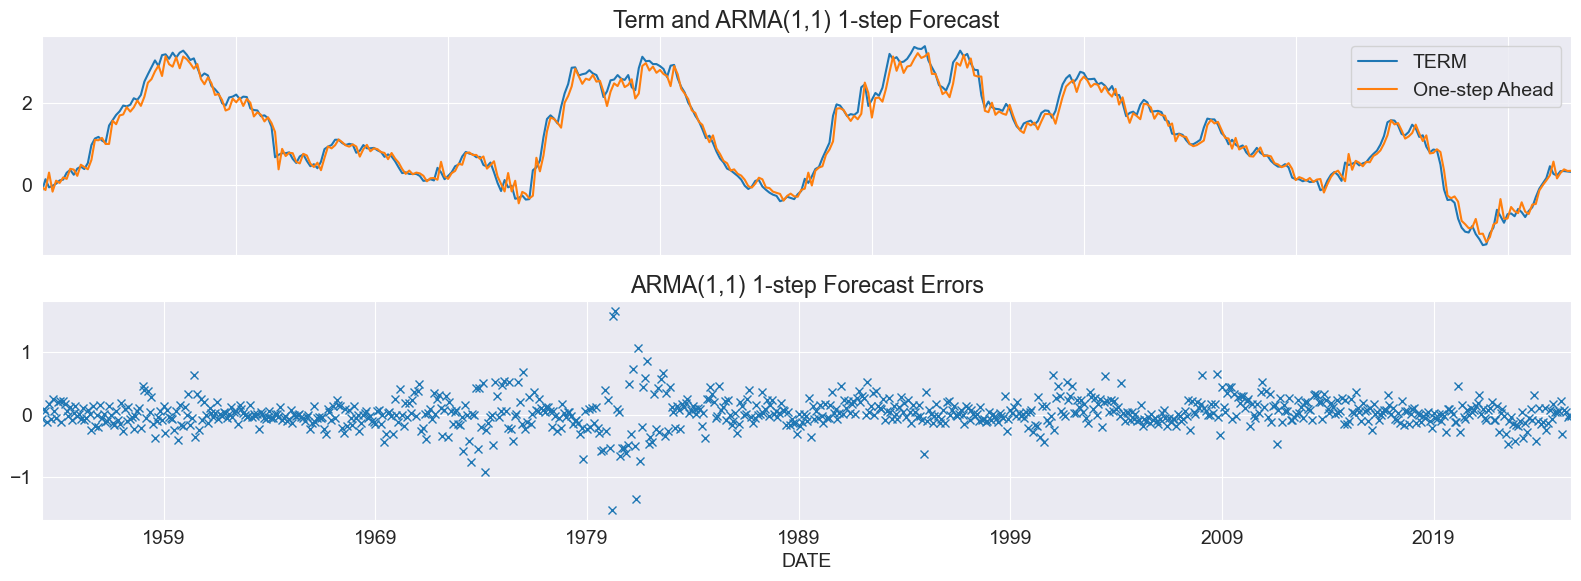

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=14)

both = pd.concat([term, fcast], axis=1)
both.columns = ["TERM", "One-step Ahead"]
both_oos = both.iloc[half:]
fig, axes = plt.subplots(2, 1)
both_oos.plot.line(ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel("")
axes[0].set_title("Term and ARMA(1,1) 1-step Forecast")
errors = both.TERM - both["One-step Ahead"]
errors.plot.line(ax=axes[1], linestyle="none", marker="x")
axes[1].set_title("ARMA(1,1) 1-step Forecast Errors")
fig.tight_layout(pad=1.0)

In [5]:
import statsmodels.api as sm

oos_fcast = sm.add_constant(fcast.iloc[half:])
oos_fcast.columns = ["Const", "Forecast"]
res = sm.OLS(oos_errors, oos_fcast).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     52.28
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           2.20e-12
Time:                        15:17:59   Log-Likelihood:                 151.57
No. Observations:                 434   AIC:                            -299.1
Df Residuals:                     432   BIC:                            -291.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const         -0.0181      0.012     -1.474      0.141      -0.042       0.006
Forecast       0.0557      0.008      7.230      0.000       0.041       0.071
==============================================================================
Omnibus:                       22.089   Durbin-Watson:                   2.250
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.969
Skew:                           0.239   Prob(JB):                     2.33e-11
Kurtosis:                       4.574   Cond. No.                         3.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
import numpy as np

r_matrix = np.eye(2)
res.wald_test(r_matrix, scalar=True)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=43.297878848680156, p=7.268319400268935e-18, df_denom=432, df_num=2>

In [7]:
rw_forecast = term.shift(1)
both = pd.concat([term, rw_forecast], axis=1)
rw_error = term - rw_forecast
rw_oos_error = rw_error.iloc[half:]
rw_forecast = sm.add_constant(rw_forecast)
rw_forecast = rw_forecast.iloc[half:]
rw_forecast.columns = ["Const", "One-step RW Forecast"]
res = sm.OLS(rw_oos_error, rw_forecast).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TERM   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.070
Date:                Wed, 27 Aug 2025   Prob (F-statistic):             0.0804
Time:                        15:17:59   Log-Likelihood:                 132.89
No. Observations:                 434   AIC:                            -261.8
Df Residuals:                     432   BIC:                            -253.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Const                    0.0173      0.013      1.367      0.172      -0.008       0.042
One-step RW Forecast    -0.0132      0.008     -1.752      0.080      -0.028       0.002
==============================================================================
Omnibus:                       33.031   Durbin-Watson:                   1.417
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.090
Skew:                           0.335   Prob(JB):                     4.51e-20
Kurtosis:                       5.116   Cond. No.                         3.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
res.wald_test(r_matrix, scalar=True)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.5418527400748274, p=0.21515948042431157, df_denom=432, df_num=2>

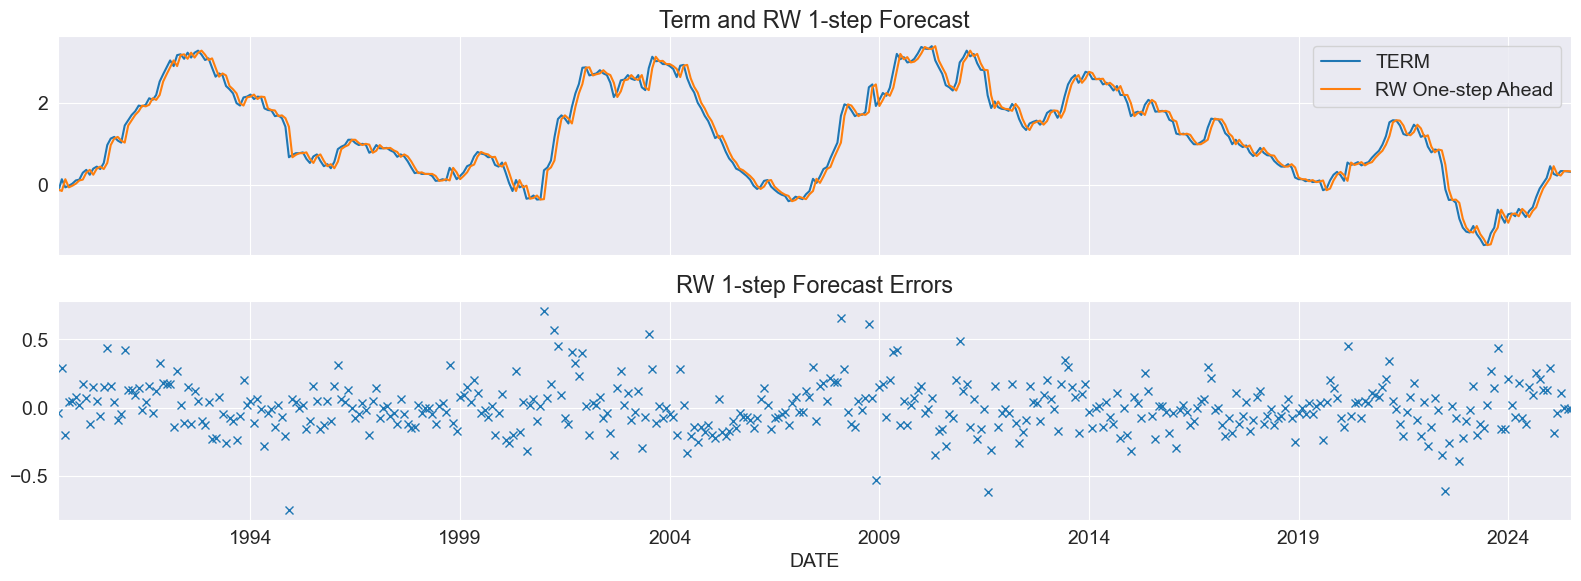

In [9]:
plt.rc("figure", figsize=(16, 6))

both.columns = ["TERM", "RW One-step Ahead"]
both_oos = both.iloc[half:]
fig, axes = plt.subplots(2, 1)
both_oos.plot.line(ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel("")
axes[0].set_title("Term and RW 1-step Forecast")

errors = rw_oos_error
errors.plot.line(ax=axes[1], linestyle="none", marker="x")
axes[1].set_title("RW 1-step Forecast Errors")
fig.tight_layout(pad=1.0)

### Exercise 71

Produce 3-step forecasts from the models selected in the previous exercises as well as a random walk model.

1. Compare these forecasts to the random walk models using MSE and MAE.


In [10]:
nobs = term.shape[0]
half = nobs // 2
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

mod = tsa.statespace.SARIMAX(term, order=(1, 0, 1), trend="c")
forecast_res = mod.filter(res.params)

In [11]:
three_step = {}
for t in range(half, nobs):
    fcasts = forecast_res.predict(t, t + 2, dynamic=True)
    key = fcasts.index[-1]
    value = fcasts.iloc[-1]
    three_step[key] = value
three_step = pd.Series(three_step)

In [12]:
three_step_errors = term - three_step
three_step_errors = three_step_errors.dropna()
three_step_errors

1989-08-01   -0.125913
1989-09-01   -0.025293
1989-10-01   -0.322081
1989-11-01    0.137237
1989-12-01   -0.061069
                ...   
2025-03-01   -0.066969
2025-04-01   -0.229963
2025-05-01    0.104445
2025-06-01   -0.015242
2025-07-01   -0.095809
Length: 432, dtype: float64

In [13]:
three_step_rw = term.shift(3)
three_step_rw_errors = term - three_step_rw
three_step_rw_errors = three_step_rw_errors.iloc[half:]

In [14]:
errors = pd.DataFrame({"ARMA": three_step_errors, "RW": three_step_rw_errors}).dropna()
pd.DataFrame([(errors**2).mean(), errors.abs().mean()], index=["MSE", "MAE"])

,ARMA,RW
MSE,0.203035,0.135943
MAE,0.343436,0.280856


In [15]:
d = errors["ARMA"] ** 2 - errors["RW"] ** 2
x = np.ones_like(d)
maxlags = int(d.shape[0] ** (1 / 3))
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 27 Aug 2025   Prob (F-statistic):                nan
Time:                        15:18:00   Log-Likelihood:                 5.0461
No. Observations:                 432   AIC:                            -8.092
Df Residuals:                     431   BIC:                            -4.024
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0671      0.023      2.949      0.003       0.023       0.112
==============================================================================
Omnibus:                       87.071   Durbin-Watson:                   0.478
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.948
Skew:                           0.987   Prob(JB):                     3.87e-49
Kurtosis:                       5.913   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""

In [16]:
d = errors["ARMA"].abs() - errors["RW"].abs()
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 27 Aug 2025   Prob (F-statistic):                nan
Time:                        15:18:00   Log-Likelihood:                -34.333
No. Observations:                 432   AIC:                             70.67
Df Residuals:                     431   BIC:                             74.73
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0626      0.024      2.585      0.010       0.015       0.110
==============================================================================
Omnibus:                        0.200   Durbin-Watson:                   0.552
Prob(Omnibus):                  0.905   Jarque-Bera (JB):                0.227
Skew:                           0.052   Prob(JB):                        0.893
Kurtosis:                       2.957   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""